In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD

#from keras import backend as K
#K.set_image_dim_ordering('tf')

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from time import gmtime, strftime

Using TensorFlow backend.


In [2]:
import os
print os.getcwd()

/home/alexandr/projects/diplom/source


In [3]:
inc_model=InceptionV3(include_top=False,
                      weights='imagenet',
                      input_shape=((150, 150, 3)))

bottleneck_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = bottleneck_datagen.flow_from_directory('data/img_train/',
                                                         target_size=(150, 150),
                                                         batch_size=20,
                                                         class_mode=None,
                                                         shuffle=False)

validation_generator = bottleneck_datagen.flow_from_directory('data/img_val/',
                                                              target_size=(150, 150),
                                                              batch_size=20,
                                                              class_mode=None,
                                                              shuffle=False)

Found 2001 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [16]:
bottleneck_features_train = inc_model.predict_generator(train_generator, 100)
print bottleneck_features_train.shape
np.save(open('bottleneck_features/bn_features_train.npy', 'wb'), bottleneck_features_train)

bottleneck_features_validation = inc_model.predict_generator(validation_generator, 30)
print bottleneck_features_validation.shape
np.save(open('bottleneck_features/bn_features_validation.npy', 'wb'), bottleneck_features_validation)

NameError: name 'inc_model' is not defined

In [6]:
from keras.layers import Flatten, Dense, Dropout

train_data = np.load(open('bottleneck_features/bn_features_train.npy', 'rb'))
train_labels = np.array([0] * 1000 + [1] * 1000)

validation_data = np.load(open('bottleneck_features/bn_features_validation.npy', 'rb'))
validation_labels = np.array([0] * 300 + [1] * 300)

fc_model = Sequential()
fc_model.add(Flatten(input_shape=train_data.shape[1:]))
fc_model.add(Dense(64, activation='relu', name='dense_one'))
fc_model.add(Dropout(0.5, name='dropout_one'))
fc_model.add(Dense(64, activation='relu', name='dense_two'))
fc_model.add(Dropout(0.5, name='dropout_two'))
fc_model.add(Dense(1, activation='sigmoid', name='output'))

fc_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

fc_model.fit(train_data, train_labels,
            nb_epoch=50, batch_size=32,
            validation_data=(validation_data, validation_labels))

fc_model.save_weights('bottleneck_features/fc_inception_cats_dogs_250.hdf5')

NameError: name 'np' is not defined

In [6]:
from keras.layers import Flatten, Dense, Dropout
x = Flatten()(inc_model.output)
x = Dense(64, activation='relu', name='dense_one')(x)
x = Dropout(0.5, name='dropout_one')(x)
x = Dense(64, activation='relu', name='dense_two')(x)
x = Dropout(0.5, name='dropout_two')(x)
top_model=Dense(1, activation='sigmoid', name='output')(x)
model = Model(input=inc_model.input, output=top_model)

#Загрузим в неё веса
weights_filename='bottleneck_features/fc_inception_cats_dogs_250.hdf5'
model.load_weights(weights_filename, by_name=True)

for layer in inc_model.layers[:205]:
    layer.trainable = False
    
model.compile(loss='binary_crossentropy',
          optimizer=SGD(lr=1e-4, momentum=0.9),
            #optimizer='rmsprop',
          metrics=['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ou..., inputs=Tensor("in...)`
  


In [7]:
filepath="new_model_weights/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/img_train/',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'data/img_val/',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


pred_generator=test_datagen.flow_from_directory('data/img_val/',
                                                     target_size=(150,150),
                                                     batch_size=100,
                                                     class_mode='binary')

Found 2001 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [22]:
model.fit_generator(
        train_generator,
        samples_per_epoch=2000,
        nb_epoch=40,
        validation_data=validation_generator,
        nb_val_samples=100,
    callbacks=callbacks_list)

NameError: name 'model' is not defined

In [10]:
model.load_weights('new_model_weights/weights-improvement-16-0.93.hdf5', by_name=True)
model.evaluate_generator(pred_generator, val_samples=100)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras.pre..., steps=100)`
  


[0.22266596316359938, 0.96869998812675473]

In [11]:
from keras.preprocessing.image import img_to_array

imgs,labels=pred_generator.next()
array_imgs=np.transpose(np.asarray([img_to_array(img) for img in imgs]),(0,2,1,3))
predictions=model.predict(imgs)
rounded_pred=np.asarray([round(i) for i in predictions])

In [14]:
pd.value_counts(labels)

0.0    50
1.0    50
dtype: int64

In [15]:
pd.crosstab(labels,rounded_pred)

col_0  0.0  1.0
row_0          
0.0     45    5
1.0      1   49

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("data/img_train/dogs/dog.0.jpg")
print image.shape
#plt.imshow(image)
#plt.show()

(375, 499, 3)


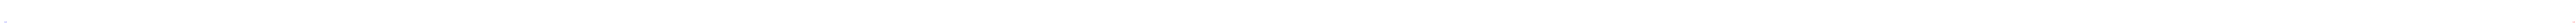

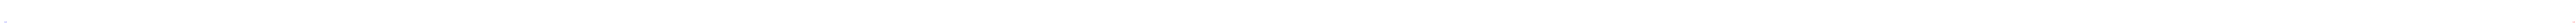

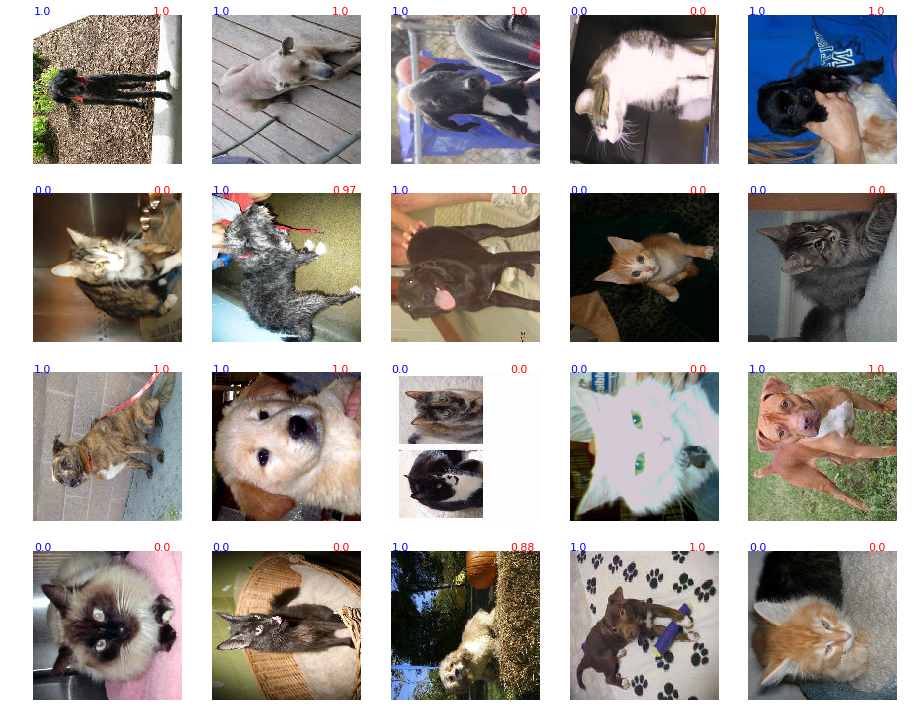

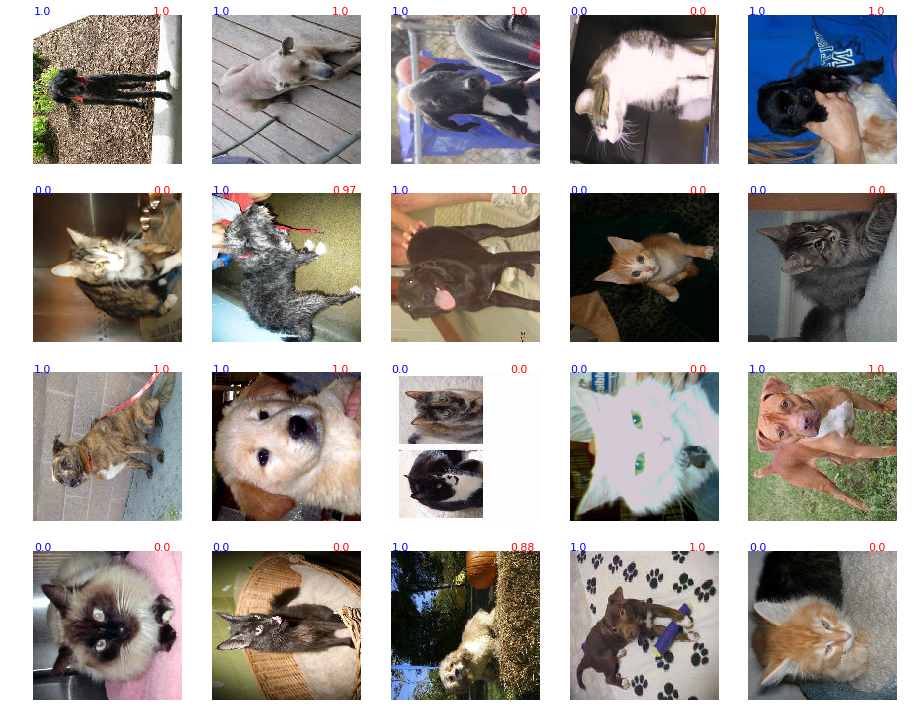

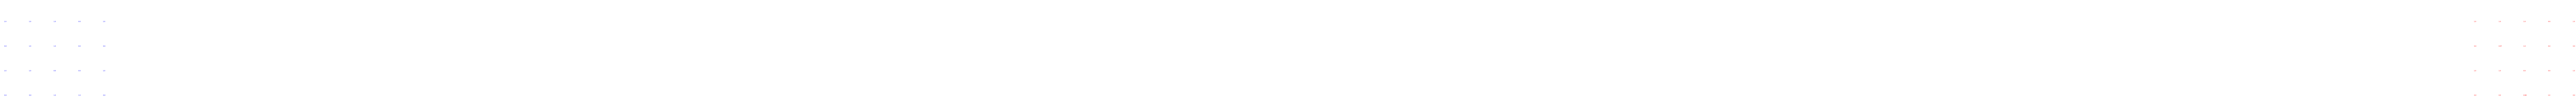

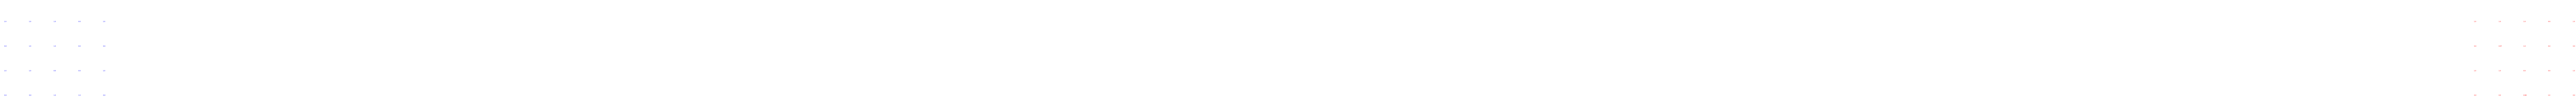

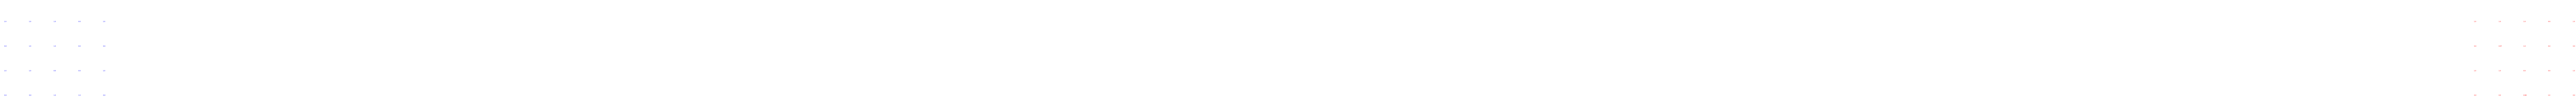

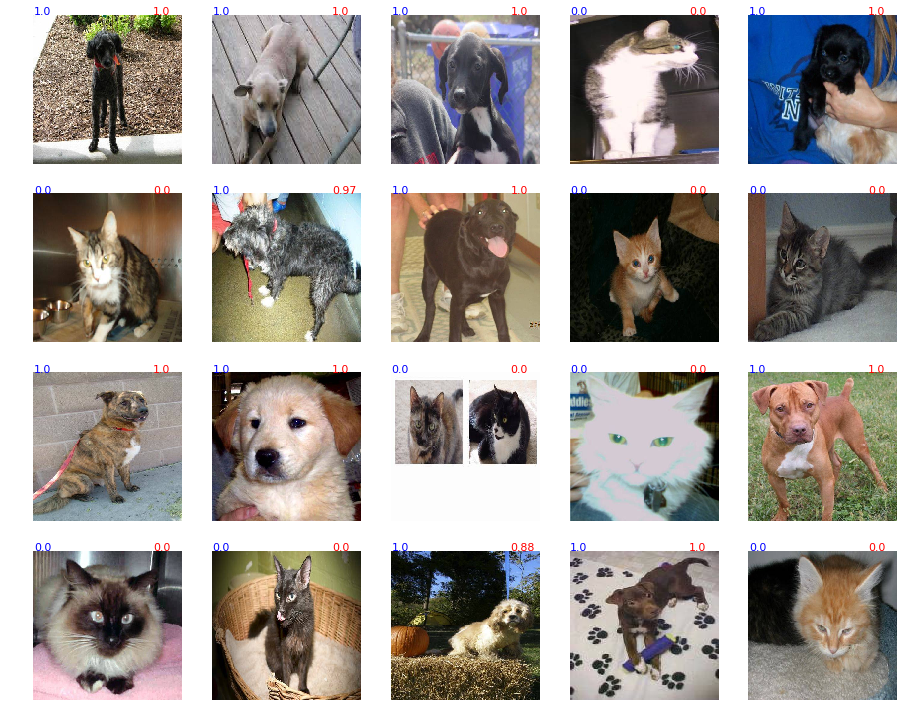

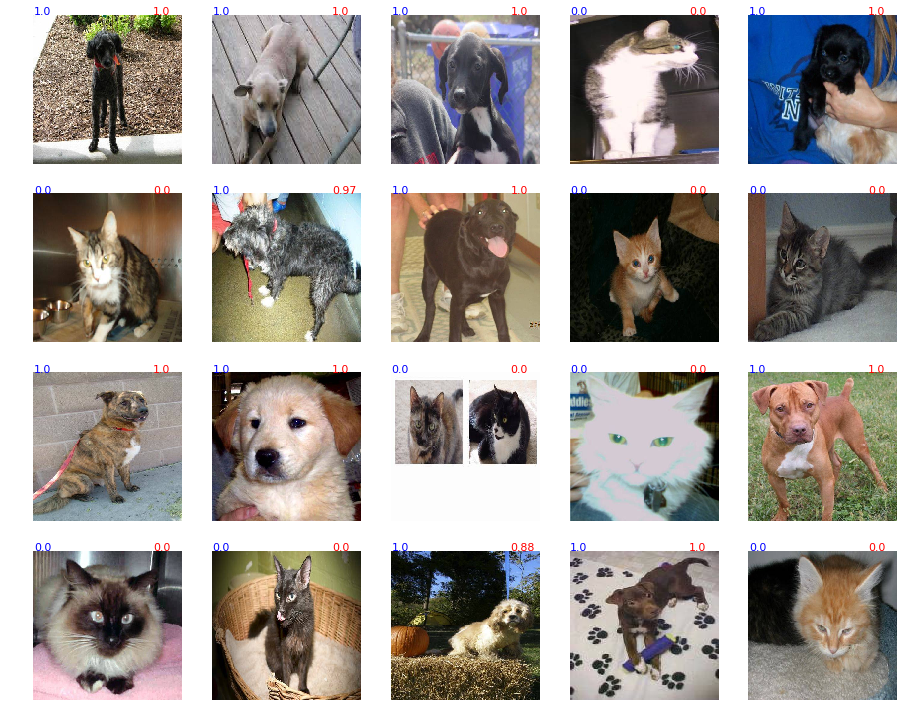

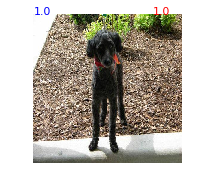

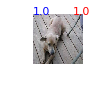

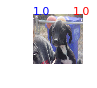

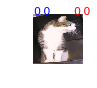

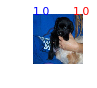

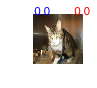

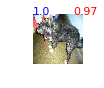

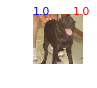

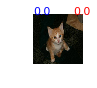

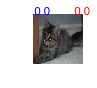

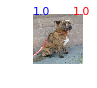

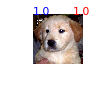

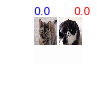

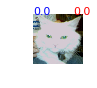

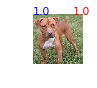

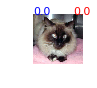

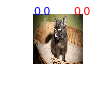

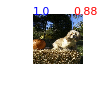

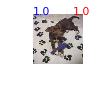

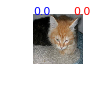

In [26]:
right=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if im[1]==im[2]]

plt.figure(figsize=(12,12))
for ind, val in enumerate(right[:20]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im=val[0]
    plt.axis('off')
    plt.text(120, 0, round(val[3], 2), fontsize=11, color='red')
    plt.text(0, 0, val[2], fontsize=11, color='blue')
    #print np.transpose(im,(1,0, 2)).shape
    plt.imshow(np.transpose(im,(1,0, 2)))
    plt.show()
    #print np.squeeze(im)
    #print np.squeeze(im, axis=(2, ))
    #plt.imshow(np)
    #plt.imshow(np.transpose(im,(2,1,0)))

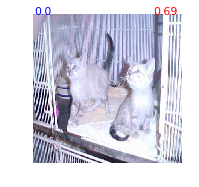

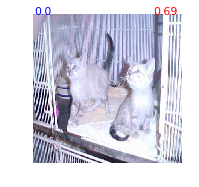

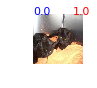

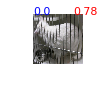

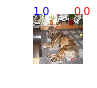

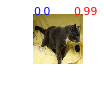

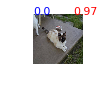

In [28]:
wrong=[im for im in zip(array_imgs, rounded_pred, labels, predictions) if im[1]!=im[2]]

plt.figure(figsize=(12,12))
for ind, val in enumerate(wrong[:100]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(5,5,ind+1)
    im=val[0]
    plt.axis('off')
    plt.text(120, 0, round(val[3], 2), fontsize=11, color='red')
    plt.text(0, 0, val[2], fontsize=11, color='blue')
    plt.imshow(np.transpose(im,(1,0,2)))
    plt.show()